In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.special import gamma

In [2]:
class CmbPy():
  """
  A class for generating 2D power specta and some analysis of the results.

  Description
  ----------

  Found the below useful for this computation:
  https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/

  Args
  ----------
  `amplitude`: float, default = 1.
      Amplitude of the momentum-space power spectrum.
  `power`: float, default = 1.75
      Exponent of k in the denominator of momentum-space power spectrum.
  `size_exponent`: int, default = 5
      Sets the grid size to be N = 2 ** size_exponent.
  `dimensions`: int, default = 2
      Number of space dimensions, currently only dimensions = 2 is implemented.
  """

  def __init__(self, amplitude=1., power=1.75, size_exponent=5, dimensions=2):
    self.amplitude = amplitude
    self.power = power
    self._size = int(2 ** size_exponent)
    if dimensions != 2:
      raise NotImplementedError('dimensions != 2 has not yet been implemented.')
    self.dimensions = dimensions

    # If P(k)=amplitude/k^{power}, then the corresponding position-space correlator
    # is G(x)=_x_amplitude/x^{dims-power} with _x_amplitude as below.
    self._x_amplitude_numerator = self.amplitude * \
      gamma(1 - (self.power / 2)) / (2 * np.pi / self._size) ** 2
    self._x_amplitude_denominator = (
      np.pi * (2 ** self.power)) * gamma(self.power / 2)

  def generate(self):
    """
    Generating the spectrum.
    """    
    # Creating a grid w/ each point pulled from std normal.
    gaussian_seed = np.random.normal(
      size=[self._size for _ in range(self.dimensions)]
    )
    # Numpy's fft algorithm automatically indexes with negative values on right half
    # positive on left half, as desired.
    gaussian_seed_fourier = np.fft.fft2(gaussian_seed)

    # Generating the fft momenta indices and their norms.
    kvector = np.fft.fftfreq(self._size) * self._size
    kx, ky = np.meshgrid(kvector, kvector, indexing='ij')
    knorms = np.sqrt(kx ** 2 + ky ** 2)
    # Regulate the k=0 divergence, if necessary.
    if self.power > 0: knorms[0, 0] = np.inf
    self._knorms = knorms
    # Create a similar spatial grid for later use.
    xvector = np.arange(-self._size + 1, self._size)
    xx, yy = np.meshgrid(xvector, xvector, indexing='ij')
    xnorms = np.sqrt(xx ** 2 + yy ** 2)
    if self.dimensions - self.power > 0:
      xnorms_mid = len(xvector) // 2
      xnorms[xnorms_mid, xnorms_mid] = np.inf
    self._xnorms = xnorms

    # Generate the realizations in k- and x-space
    power_spectrum = self.amplitude * ((knorms) ** (-1 * self.power))
    power_spectrum_sqrt = np.sqrt(power_spectrum)
    self._k_realization = gaussian_seed_fourier * power_spectrum_sqrt
    # Transform back and take the real part to get the spectrum.
    self._x_realization = np.real(np.fft.ifft2(self._k_realization))
    # Imaginary parts should be from numerical errors and extremely small.
    abs_im_to_re_ratio = np.abs(np.imag(np.fft.ifft2(self._k_realization)) /
      np.real(np.fft.ifft2(self._k_realization))).mean()
    # The mean should also be nearly zero.  Sanity check both
    assert abs_im_to_re_ratio < 1e-10, 'Sanity check failed: ratio of imaginary to real parts > 1e-10'
    assert self._x_realization.mean() < 1e-10, 'Sanity check failed: mean of position-space realization > 1e-10'

In [3]:
#Make nice CMB-like powerspectrum
c = CmbPy(size_exponent=10, power=3)
c.generate()

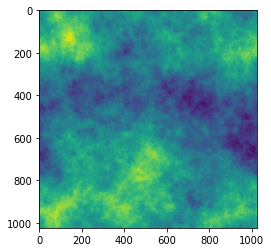

In [5]:
plt.imshow(c._x_realization)

#save pretty image
path = "../tmp/GAUß.fits"
hdu = fits.PrimaryHDU(c._x_realization)
hdu.writeto(path, overwrite=True)